In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from general.pulses import blackman_pulse, square_pulse
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += colors

from general.plot_settings import paper_settings
plt.rcParams.update(paper_settings)

from matplotlib.ticker import NullLocator
from amo.constants import hbar

AttributeError: module 'numpy' has no attribute 'trapezoid'

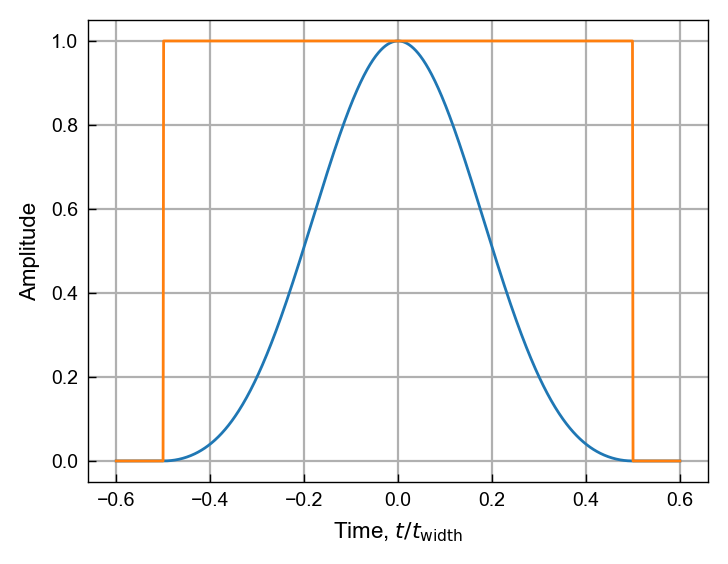

In [2]:
t_min, t_max = (-6, 6)
num = 1000
t = np.linspace(t_min, t_max, num)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(t/t_width, blackman_pulse(t+t_width/2, t_width))
ax.plot(t/t_width, square_pulse(t+t_width/2, t_width))
ax.grid(True)
ax.set(xlabel=r"Time, $t/t_\mathrm{width}$", ylabel="Amplitude")

dt = (t_max - t_min)/num/t_width
A_blackman = np.trapezoid(blackman_pulse(t+t_width/2, t_width), dx=dt)
A_square = np.trapezoid(square_pulse(t+t_width/2, t_width), dx=dt)
A2_blackman = np.trapezoid(blackman_pulse(t+t_width/2, t_width)**2, dx=dt)
A2_square = np.trapezoid(square_pulse(t+t_width/2, t_width)**2, dx=dt)

print(f"The area of the square pulse is {A_square}")
print(f"The area of the Blackman pulse is {A_blackman}")
print(f"The area ratio is {A_blackman/A_square}")

print(f"The area of the square pulse squared is {A2_square}")
print(f"The area of the Blackman pulse squared is {A2_blackman}")
print(f"The squared area ratio is {A2_blackman/A2_square}")

plt.show()

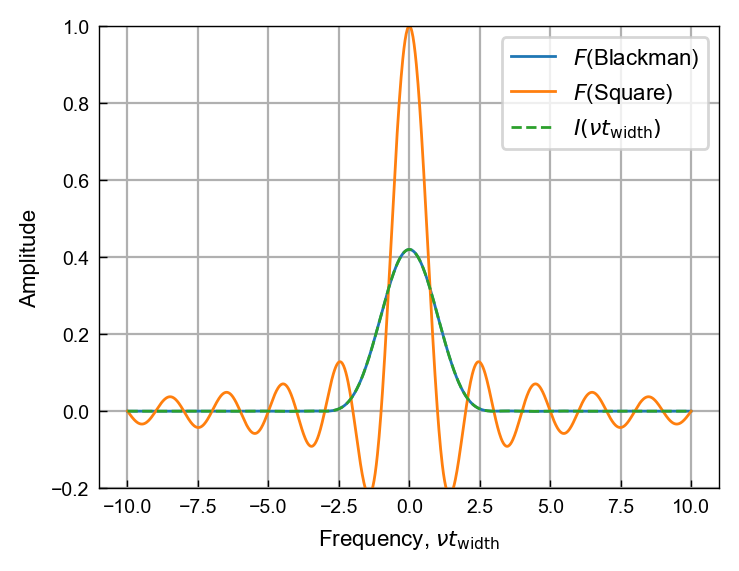

In [3]:
from general.pulses import blackman_fourier, blackman_instrument

nu = np.linspace(-1, 1, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu * t_width, blackman_fourier(nu, t_width)/t_width, label=r'$F$(Blackman)')
ax.plot(nu * t_width, t_width*np.sinc(t_width*nu)/t_width, label=r'$F$(Square)')
ax.plot(nu * t_width, blackman_instrument(nu, t_width)/t_width, '--', label=r'$I(\nu t_\mathrm{width})$')
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu t_\mathrm{width}$", ylabel="Amplitude", ylim=[-0.2, 1])
ax.legend(loc="upper right")

plt.show()

In [4]:
0.42


0.42

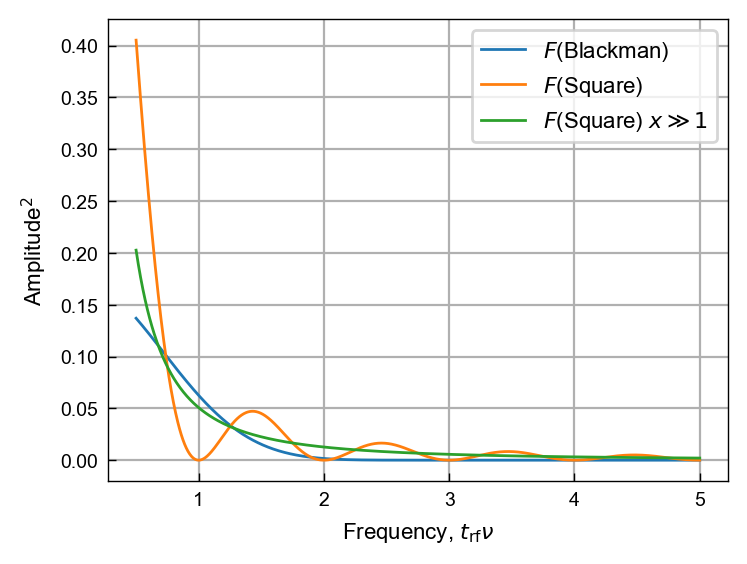

In [4]:
from general.pulses import blackman_fourier

nu = np.linspace(0.05, 0.5, 1000)

def large_x_sinc(x):
    return 1/np.sqrt(2)* np.piecewise(x, [x==0, x!=0], [1, lambda x: 1/(np.pi * x)])

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu * t_width, (blackman_fourier(nu, t_width)/t_width)**2, label=r'$F$(Blackman)')
ax.plot(nu * t_width, np.sinc(t_width*nu)**2, label=r'$F$(Square)')
ax.plot(nu * t_width, large_x_sinc(t_width*nu)**2, label=r'$F$(Square) $x\gg1$') 
ax.grid(True)
ax.set(xlabel=r"Frequency, $t_\mathrm{rf} \nu$", ylabel=r"Amplitude$^2$")
ax.legend(loc="upper right")

# ratio = (blackman_fourier(nu_test, t_width)/t_width)**2/large_x_sinc(t_width*nu_test)**2

# print(f"Average SquareFourier^2 at large x compared to BlackmanFourier^2 is {ratio}")

plt.show()

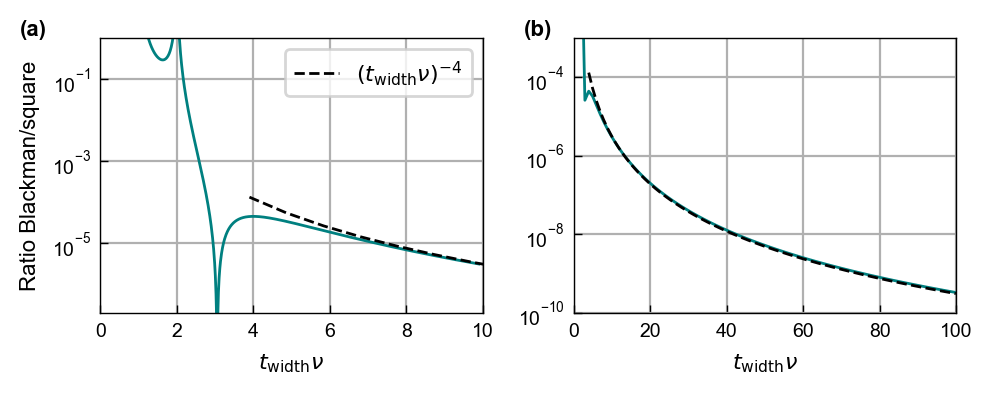

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))

def ratio_func(det):
    return (blackman_fourier(det, 1))**2/np.sinc(det)**2

ax = axs[0]
detuning = np.linspace(0.9, 9.9, 1000)
ax.plot(detuning, ratio_func(detuning), color='teal')
detuning = np.linspace(3.9, 99.9, 100)
ax.plot(detuning, detuning**(-4)/33, '--', label=r'$(t_\mathrm{width} \nu)^{-4}$', color='k')
ax.grid(True)
ax.set(xlabel=r"$t_\mathrm{width} \nu$", ylabel=r"Ratio Blackman/square",
       yscale='log', ylim=(2e-7, 1), xlim=(0, 10))
ax.minorticks_off()
ax.legend()

ax = axs[1]
detuning = np.linspace(0.9, 99.9, 100)
ax.plot(detuning, ratio_func(detuning), color='teal')
detuning = np.linspace(3.9, 99.9, 100)
ax.plot(detuning, detuning**(-4)/33, '--', color='k')
ax.grid(True)
ax.set(xlabel=r"$t_\mathrm{width} \nu$", yscale='log', ylim=(1e-10, 1e-3), xlim=(0, 100))

fig.tight_layout()

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.21, -0.13]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.01, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.90)

fig.savefig("outputs/blackman_vs_square_pulse_detuning.pdf")

plt.show()

## Convolution of Blackman on -3/2s tail

In [7]:
from general.pulses import blackman_convolution_correction

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += colors

# --- Parameters ---
x_a = 4                 # Rollover to -5/2s tail.
HFT_cutoff = 50e3       # Set minimum detuning to be 50kHz.


t_widths = np.array([0.1, 0.2, 0.4, 0.8, 1.0, 5., 10., 12., 15., 17., 20., 30., 40., 60., 120., 200., 
                     2000., 20000.
                     ]) * 1e-6  # us
detunings = 3/t_widths  # Detuning of Blackman pulse in MHz
detunings[detunings < HFT_cutoff] = HFT_cutoff

Ms = np.zeros_like(t_widths)

Ms = np.array([blackman_convolution_correction(d, t) for d, t in zip(detunings, t_widths)])

# for trf, M in zip(t_widths, Ms):
#     print(f"For {t_width:.1f}us pulse, overestimation is {M:.3f}.")


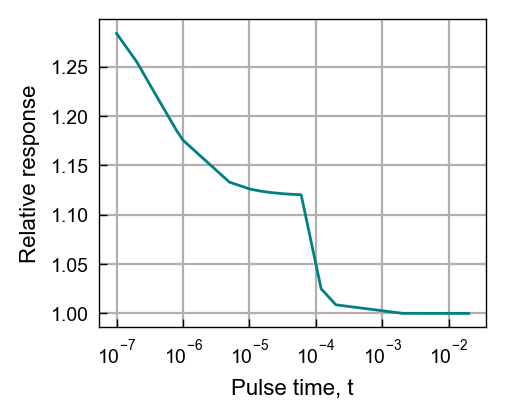

In [12]:
fig, ax = plt.subplots(figsize=(2.5,2))
ax.plot(t_widths, Ms, color='teal')
ax.set(xlabel="Pulse time, t", ylabel="Relative response", xscale='log')
ax.grid(True)
ax.minorticks_off()

plt.show()

## Single-particle residue contamination

### Fermi time or 11us pulse

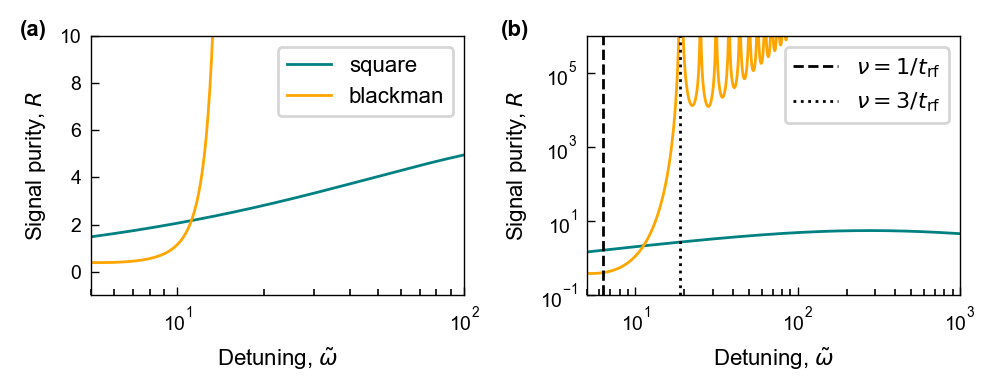

In [6]:
colors = ['teal', 'orange']

tau_F = 11e-6
trf = 11e-6

omega_trf = 2*np.pi/trf * tau_F
omega_a = 2 * np.pi * 4e6 * tau_F
OmegaR = 2 / trf
C = 3

def alpha_HFT(omega):
    return 2**(-3/2)/np.pi * tau_F * trf * C * omega**(-3/2) * OmegaR**2 / (1+omega/omega_a)

def alpha_res(omega):
    nu = omega/tau_F/2/np.pi
    return np.sinc(trf * nu)**2 * OmegaR**2 / 4 * trf**2

def alpha_res_lim(omega):
    return  OmegaR**2/(omega/tau_F)**2/2

def alpha_HFT_blackman(omega):
    return alpha_HFT(omega) * 0.305

def alpha_res_blackman(omega):
    nu = omega/tau_F/2/np.pi
    return (blackman_instrument(nu, trf)/trf)**2 * OmegaR**2 / 4 * trf**2

fig, axs = plt.subplots(1, 2, figsize=(5, 2))


ax = axs[0]
ylims = (-1, 10)
xlims = (5, 100)
detuning = np.linspace(*xlims, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       xscale='log', ylim=ylims, xlim=xlims)
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning), label='square', color=colors[0])
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning), label='blackman', color=colors[1])

ax.legend()

ax = axs[1]
ylims = (0.1, 1e6)
xlims = (5, 1000)
detuning = np.logspace(np.log10(5), 3, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       xscale='log', yscale='log', ylim=ylims, xlim=xlims)
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning), color=colors[0])
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning), color=colors[1])
ax.vlines(omega_trf, *ylims, 'k', '--', label=r'$\nu = 1/t_\mathrm{rf}$')
ax.vlines(3*omega_trf, *ylims, 'k', ':', label=r'$\nu = 3/t_\mathrm{rf}$')
ax.legend()
ax.yaxis.set_minor_locator(NullLocator())

fig.tight_layout()

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.19, -0.23]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.00, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.90)

fig.savefig("outputs/signal_purity.pdf")
plt.show()


In [89]:
nu = 14.5
alpha_HFT_blackman(nu)/alpha_res_blackman(nu)
np.max(alpha_HFT(detuning)/alpha_res_lim(detuning))

np.float64(5.613612043447473)

In [86]:
2*np.pi**2*100



1973.9208802178716

In [90]:
2400/1e2

24.0

### 400us pulse

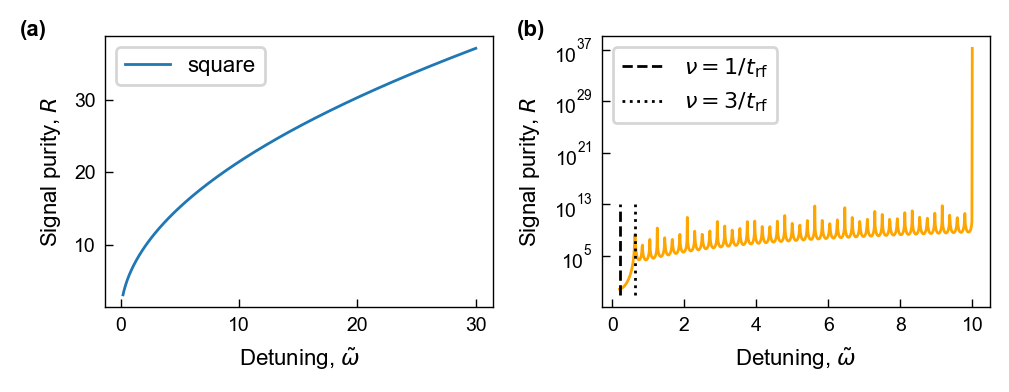

In [15]:
EF = 12e3
tau_F = 1/(EF * 2 * np.pi)  # in seconds
trf = 400e-6

omega_trf = 2*np.pi/trf * tau_F

OmegaR = 2 / trf
C = 1

def alpha_HFT(omega):
    return 2**(-3/2)/np.pi * tau_F * trf * C * omega**(-3/2) * OmegaR**2

def alpha_res(omega):
    nu = omega/tau_F/2/np.pi
    return np.sinc(trf * nu)**2 * OmegaR**2 / 4 * trf**2

def alpha_res_lim(omega):
    return  OmegaR**2/(omega/tau_F)**2/2

def alpha_HFT_blackman(omega):
    return alpha_HFT(omega) * 0.305

def alpha_res_blackman(omega):
    nu = omega/tau_F/2/np.pi
    return (blackman_instrument(nu, trf)/trf)**2 * OmegaR**2 / 4 * trf**2

fig, axs = plt.subplots(1, 2, figsize=(5, 2))


ax = axs[0]
detuning = np.linspace(0.2, 30, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$')
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning), label='square')

ax.legend()

ax = axs[1]
ylims = (0.1, 1e13)
xlims = (0.2, 10)
detuning = np.linspace(*xlims, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       yscale='log')
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning), color=colors[1])
ax.vlines(omega_trf, *ylims, 'k', '--', label=r'$\nu = 1/t_\mathrm{rf}$')
ax.vlines(3*omega_trf, *ylims, 'k', ':', label=r'$\nu = 3/t_\mathrm{rf}$')
ax.legend()

fig.tight_layout()

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.22, -0.22]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.00, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.90)

fig.savefig("outputs/signal_purity_400us.pdf")
plt.show()

In [14]:
tau_F

1.3262911924324612e-05

In [80]:
0.42**2

0.17639999999999997

## Dimer signal contamination

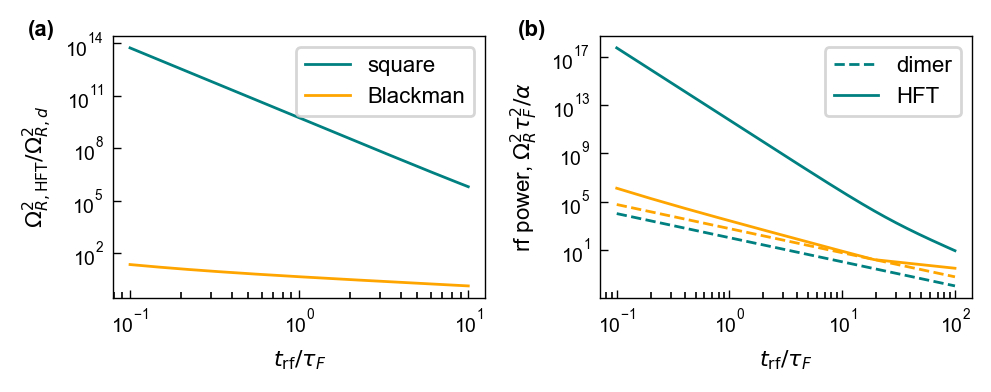

In [71]:
# import numpy as np
# R = 1
# omega_tilde_factors = (np.sqrt(2) * np.pi * 0.18**2 * (2*np.pi)**4/0.305)**(2/9)

# num_factors = omega_tilde_factors**6 * 2 /((2*np.pi)**4 * 0.18**2)

# print(num_factors/1e4)
# omega_d = 2*np.pi*4e6
# C = 1
# kF_ell_d = 4*np.pi/1e2
# R = 10
# factor = ((2*np.pi)**5*R/kF_ell_d/C * 0.18**2/0.42**2)**(1/6)
# trf = omega_d**(-1) * factor

# trf*1e6
# factor
# R = 10
# C = 1

# ratio = (0.026)*(0.42**2) * kF_ell_d/4/np.pi * R**(1/3) /C**(1/3)
# ratio
# (0.18**2 * (2*np.pi)**4 * np.sqrt(2)*np.pi / 0.305)**(2/9)
# 4.3*10**(2/9) * 15

tau_F = 11e-6
omega_d = 2*np.pi * 4e6
tildeomega_a = omega_d * tau_F
C = 1
kF_ell_d = 4*np.pi / 1e2
R = 100

HFT_cutoff = 1


def dimer_power(t):
    """Dimer power as \Omega_R^2\tau_F^2/\alpha_d as a function of
    time in Fermi time units."""
    return 4*np.pi/kF_ell_d/C *t**(-2)


def dimer_power_blackman(t):
    """Dimer power as \Omega_R^2\tau_F^2/\alpha_d as a function of
    time in Fermi time units, for a Blackman pulse."""
    return 4*np.pi/kF_ell_d/C *t**(-2) / 0.42**2


def omega_clean(t):
    """Returns the tilde omega needed to maintain R signal purity for a 
    square pulse in the HFT."""
    omega = R**2 * 2*np.pi**2 / C**2 * t**(-2)
    omega[omega < 2] = 2
    return omega


def omega_clean_blackman(t):
    omega = 6*np.pi/t
    omega[omega < HFT_cutoff] = HFT_cutoff
    return omega


def hft_power(t, pulse=''):
    """HFT power as \Omega_R^2\tau_F^2/\alpha_HFT as a function of
    time in Fermi time units."""
    if pulse == 'Blackman':
        tildeomega = omega_clean_blackman(t)
        power = 2**(3/2)*np.pi / t / C * tildeomega**(3/2) * \
        (1 + tildeomega/tildeomega_a) / 0.305

    else:
        tildeomega = omega_clean(t)
        power = 2**(3/2)*np.pi / t / C * tildeomega**(3/2) * \
            (1 + tildeomega/tildeomega_a) 
        
    return power
    # return 8*np.pi**4 * R**3/C**4 *t**(-4)


fig, axs = plt.subplots(1, 2, figsize=(5,2))

ax = axs[1]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'rf power, $\Omega_R^2\tau_F^2/\alpha$',
       yscale='log', xscale='log')

t = np.linspace(0.1, 100, 1000)
ax.plot(t, dimer_power(t), '--', label='dimer', color=colors[0])
ax.plot(t, hft_power(t), label='HFT', color=colors[0])
# ax.plot(t, hft_power_fse(t), ':', color=colors[0])

ax.plot(t, dimer_power_blackman(t), '--', color=colors[1])
ax.plot(t, hft_power(t, pulse='Blackman'),  color=colors[1])
# ax.plot(t, hft_power_blackman_fse(t), ':',  color=colors[1])
ax.legend()


ax = axs[0]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'$\Omega_{R,\mathrm{HFT}}^2/\Omega_{R,d}^2$',
       yscale='log', xscale='log')

t = np.linspace(0.1, 10, 1000)

ax.plot(t, hft_power(t)/dimer_power(t), label='square', color=colors[0])
ax.plot(t, hft_power(t, pulse='Blackman')/dimer_power_blackman(t), label='Blackman', color=colors[1])
# ax.plot(t, hft_power_fse(t)/dimer_power(t), ':', color=colors[0])
# ax.plot(t, hft_power_blackman_fse(t)/dimer_power_blackman(t), ':', color=colors[1])
ax.legend()
ax.yaxis.set_minor_locator(NullLocator())

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.23, -0.22]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.00, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.90)

fig.tight_layout()
# fig.savefig("outputs/dimer_vs_HFT_power.pdf")

plt.show()




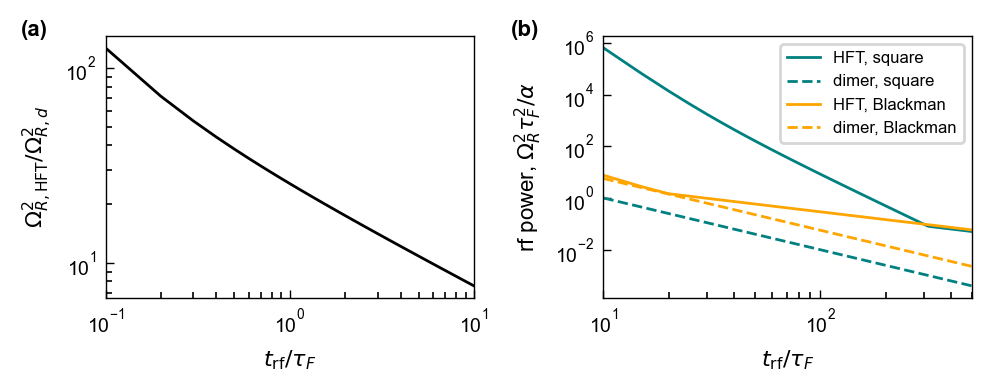

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))

ax = axs[0]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'$\Omega_{R,\mathrm{HFT}}^2/\Omega_{R,d}^2$',
       yscale='log', xscale='log', xlim=(0.1,10))

t = np.linspace(0.1, 10, 100)
ax.plot(t, hft_power(t, pulse='Blackman')/dimer_power(t), color='k')


ax = axs[1]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'rf power, $\Omega_R^2\tau_F^2/\alpha$',
       yscale='log', xscale='log', xlim=(10, 500))

t = np.linspace(10, 500, 100)
ax.plot(t, hft_power(t), label='HFT, square', color=colors[0])
ax.plot(t, dimer_power(t), '--', label='dimer, square', color=colors[0])
# ax.plot(t, hft_power_fse(t), ':', color=colors[0])

ax.plot(t, hft_power(t, pulse='Blackman'), label='HFT, Blackman',  color=colors[1])
ax.plot(t, dimer_power_blackman(t), '--', label='dimer, Blackman', color=colors[1])
# ax.plot(t, hft_power_blackman_fse(t), ':',  color=colors[1])
ax.legend(fontsize=6)
ax.yaxis.set_minor_locator(NullLocator())

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.23, -0.25]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.00, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.90)

fig.tight_layout()
fig.savefig("outputs/dimer_vs_HFT_power.pdf")

plt.show()

In [175]:
2*np.sqrt(2)*np.pi*(6*np.pi)**(3/2)/0.305

np.float64(2384.222112118256)

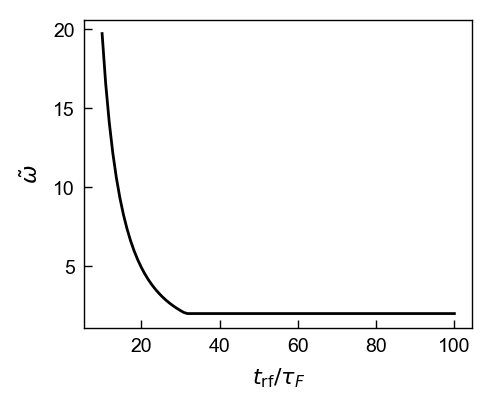

In [68]:
# t = 200

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'$\tilde\omega$')

t = np.linspace(10, 100, 100)
ax.plot(t, omega_clean(t), color='k')



In [56]:
print(R, C)

10 1


In [31]:
1*np.sqrt(1/3)

np.float64(0.5773502691896257)

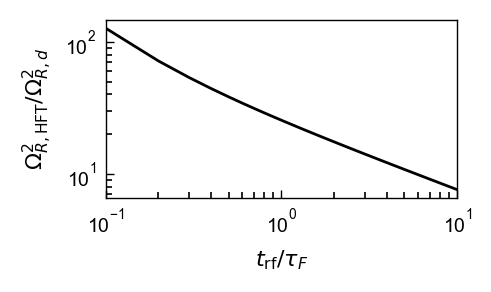

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))

ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'$\Omega_{R,\mathrm{HFT}}^2/\Omega_{R,d}^2$',
       yscale='log', xscale='log', xlim=(0.1,10))

t = np.linspace(0.1, 10, 100)
ax.plot(t, hft_power(t, pulse='Blackman')/dimer_power(t), color='k')

fig.tight_layout()
fig.savefig("outputs/short_pulse_dimer_vs_HFT.pdf")

In [77]:
hft_power(np.array([1.]), pulse='Blackman')/dimer_power(np.array([1.]))

array([25.46782711])

## Plot for figures

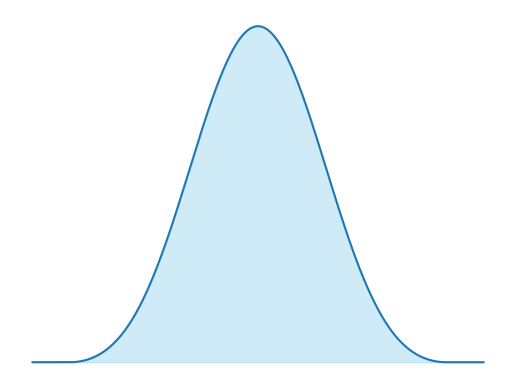

In [ ]:
t = np.linspace(-0.1, 1.1, 1000)
t_width = 1

y = blackman_pulse(t, t_width)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.fill_between(t, y, color='skyblue', alpha=0.4) 
# plt.plot(t, square_pulse(t, t_width))
ax.set(xlabel="Time, t", ylabel="Amplitude")

ax.axis('off')

plt.show()

# fig.savefig("outputs/blackman_envelope_with_fill.pdf")

## Understanding a_1 coefficient sign

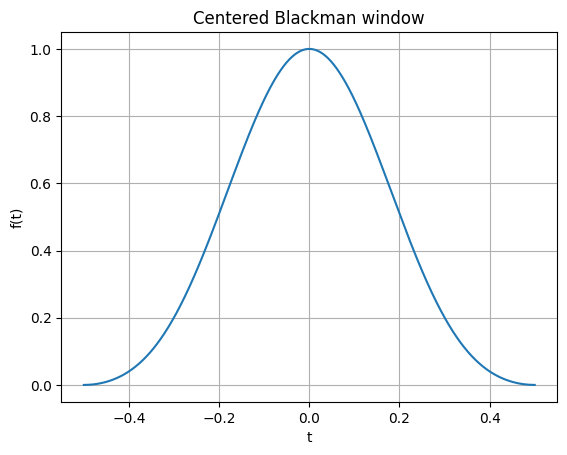

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.16
a0 = (1 - alpha)/2
a1 = 0.5
a2 = alpha/2

t_w = 1.0
t = np.linspace(-t_w/2, t_w/2, 1000)
f = a0 + a1*np.cos(2*np.pi*t/t_w) + a2*np.cos(4*np.pi*t/t_w)

plt.plot(t, f)
plt.title("Centered Blackman window")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.show()
